In [2]:
# General imports
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Iterable
import matplotlib.pyplot as plt

# ML imports
import torch
from torch.utils import data
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
import einops

# power_perceiver imports
from power_perceiver.dataset import NowcastingDataset
from power_perceiver.consts import BatchKey
from power_perceiver.data_loader import HRVSatellite, PV
from power_perceiver.xr_batch_processor import SelectPVSystemsNearCenterOfImage
from power_perceiver.np_batch_processor import EncodeSpaceTime
from power_perceiver.transforms.satellite import PatchSatellite
from power_perceiver.transforms.pv import PVPowerRollingWindow

In [3]:
#TRAIN_PATH = Path("~/dev/ocf/power_perceiver/data_for_testing/").expanduser()
TRAIN_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15/train/")
assert TRAIN_PATH.exists()

In [4]:
train_dataset = NowcastingDataset(
    data_path=TRAIN_PATH,
    data_loaders=[
        HRVSatellite(
            transforms=[PatchSatellite()]
            ), 
        PV(
            transforms=[PVPowerRollingWindow()]
            ),
    ],
    xr_batch_processors=[SelectPVSystemsNearCenterOfImage()],
    np_batch_processors=[EncodeSpaceTime()]
)

In [5]:
dataloader_kwargs = dict(
    batch_size=None,
    num_workers=16,
    pin_memory=True,
    #persistent_workers=False,
)

train_dataloader = data.DataLoader(
    train_dataset,
    **dataloader_kwargs
)

In [6]:
for batch in train_dataloader:
    break

In [7]:
@dataclass(eq=False)  # See: https://discuss.pytorch.org/t/typeerror-unhashable-type-for-my-torch-nn-module/109424/6
class Perceiver(nn.Module):
    """
    Input and output tensors are provided as shape (batch, seq, feature).
    
    Init args:
        num_heads: Number of parallel attention heads. Note that ``embed_dim`` will be split
            across ``num_heads`` (i.e. each head will have dimension ``embed_dim // num_heads``).
        dropout: Dropout probability on ``attn_output_weights``. Default: ``0.0`` (no dropout).
    """
    query_dim: int
    byte_array_dim: int
    num_heads: int = 8
    dropout: float = 0.0
    share_weights_across_latent_transformer_layers: bool = True
    num_latent_transformer_encoders: int = 4
    
    def __post_init__(self):
        super().__init__()

        # Cross attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=self.query_dim,
            num_heads=self.num_heads,
            dropout=self.dropout,
            batch_first=True,
            kdim=self.byte_array_dim,
            vdim=self.byte_array_dim
        )

        # TransformerEncoderLayer is made up of self-attn and feedforward network.
        # This standard encoder layer is based on the paper “Attention Is All You Need”
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.query_dim,
            nhead=self.num_heads,
            dropout=self.dropout,
            batch_first=True
        )

        if self.share_weights_across_latent_transformer_layers:
            transformer_encoder_layers = [transformer_encoder_layer] * self.num_latent_transformer_encoders
            self.latent_transformer = nn.Sequential(*transformer_encoder_layers)
        else:
            self.latent_transformer = nn.TransformerEncoder(
                encoder_layer=transformer_encoder_layer,
                num_layers=self.num_latent_transformer_encoders,
            )

    def forward(
            self, 
            query: torch.Tensor, 
            byte_array: torch.Tensor, 
            byte_array_padding_mask: Optional[torch.Tensor] = None
        ) -> torch.Tensor:
        """
        Args:
            query: Query embeddings of shape `(N, L, query_dim)`, where `N` is the batch size,
                and `L` is the number of query elements (the target sequence length).
                Queries are compared against key-value pairs to produce the output.
            byte_array: Key embeddings of shape `(N, S, byte_array_dim)`, where `N` is the batch size, 
                and `S` is the number of byte_array elements (the source sequence length).
            byte_array_padding_mask: If specified, a mask of shape `(N, S)` indicating which 
                elements within ``byte_array`` to ignore for the purpose of attention (i.e. treat as "padding").
                Shape should be `(N, S)`. Binary and byte masks are supported.
                For a binary mask, a ``True`` value indicates that the corresponding ``byte_array`` value
                will be ignored for the purpose of attention. For a byte mask, a non-zero value indicates
                that the corresponding ``byte_array`` value will be ignored.
                
        Returns:
            **attn_output** - Attention outputs of shape `(N, L, query_dim)`,
                where `N` is the batch size, and
                `L` is the number of query elements (the target sequence length).
        """
        attn_output, attn_weights = self.cross_attention(
            query=query, 
            key=byte_array, 
            value=byte_array, 
            need_weights=False,  # TODO: Plot attention weights.
            key_padding_mask=byte_array_padding_mask,
            )
        return self.latent_transformer(attn_output)

In [8]:
def repeat_over_time(
        x: dict[BatchKey, torch.Tensor],
        batch_keys: Iterable[BatchKey], 
        n_timesteps: int
    ) -> list[torch.Tensor]:
    repeated_tensors = []
    for batch_key in batch_keys:
        tensor = x[batch_key]
        tensor = einops.repeat(tensor, "batch_size ... -> batch_size time ...", time=n_timesteps)
        repeated_tensors.append(tensor)
    return repeated_tensors


class HRVSatelliteProcessor(nn.Module):
    def __post_init__(self):
        super().__init__()
    
    def forward(self, x: dict[BatchKey, torch.Tensor]) -> torch.Tensor:
        """Returns a byte array ready for Perceiver"""
        # Create the byte array
        # TODO:
        # Append the satellite position encoding onto the "patch" dimension.
        # Reshape the satellite imagery to the correct shape
        
        # Ignore the "channels" dimension because HRV is just a single channel:
        hrvsatellite = x[BatchKey.hrvsatellite][:, :, 0]
        
        # Repeat the fourier features for each timestep of each example:
        n_timesteps = hrvsatellite.shape[1]
        y_fourier, x_fourier = repeat_over_time(
            x=x, 
            batch_keys=(BatchKey.hrvsatellite_y_osgb_fourier, BatchKey.hrvsatellite_x_osgb_fourier),
            n_timesteps=n_timesteps)
        # y_fourier and x_fourier are now of shape batch, time, y, x, n_fourier_features
        
        # Concatenate spatial fourier features onto satellite imagery:
        byte_array = torch.concat((hrvsatellite, y_fourier, x_fourier), dim=-1)

        # Reshape so each timestep is seen as a separate example, and the 2D
        # image is flattened into a 1D array.
        byte_array = einops.rearrange(
            byte_array,
            "batch_size time y x patch -> (batch_size time) (y x) patch"
        )
        
        return byte_array
    
# Test!
HRVSatelliteProcessor()(batch).shape

torch.Size([992, 256, 32])

In [9]:
batch[BatchKey.pv_x_osgb_fourier].shape

torch.Size([32, 128, 8])

In [10]:
def masked_mean(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # Adapted from https://discuss.pytorch.org/t/how-to-write-a-loss-function-with-mask/53461/4
    masked_tensor = torch.where(mask, tensor, torch.tensor(0, dtype=tensor.dtype, device=tensor.device))
    total = masked_tensor.sum()
    num_selected_elements = mask.sum()
    return total / num_selected_elements


@dataclass(eq=False)
class QueryGenerator(nn.Module):
    """Create a query using a learnt array and the locations of the PV systems."""
    num_fourier_features: int  # TOTAL (for both x and y)
    num_elements_query_padding: int
    pv_system_id_embedding_dim: int
    num_pv_systems: int = 2000
    
    def __post_init__(self):
        super().__init__()
        self.query_dim = self.num_fourier_features + self.pv_system_id_embedding_dim
        self.query_padding = nn.Parameter(torch.randn(self.num_elements_query_padding, self.query_dim))
        self.pv_system_id_embedding = nn.Embedding(
            num_embeddings=self.num_pv_systems,
            embedding_dim=self.pv_system_id_embedding_dim,
        )
        
    def forward(self, x: dict[BatchKey, torch.Tensor]) -> torch.Tensor:
        # Repeat the fourier features for each timestep of each example:
        n_timesteps = x[BatchKey.pv].shape[1]
        y_fourier, x_fourier, pv_system_row_number = repeat_over_time(
            x=x, 
            batch_keys=(BatchKey.pv_y_osgb_fourier, BatchKey.pv_x_osgb_fourier, BatchKey.pv_system_row_number),
            n_timesteps=n_timesteps)
        # y_fourier and x_fourier are now of shape (batch, time, n_pv_systems, n_fourier_features)
        
        pv_system_embedding = self.pv_system_id_embedding(pv_system_row_number)
        
        pv_system_query = torch.concat((y_fourier, x_fourier, pv_system_embedding), dim=-1)
        del y_fourier, x_fourier, pv_system_embedding
        
        # Missing PV systems are represented as NaN in the fourier features. Fill these with zeros.
        # (We do this because we can't mask the *query*. Instead, we'll ignore missing PV
        # systems in the objective function.)
        pv_system_query = torch.nan_to_num(pv_system_query, nan=0.0)
        
        # Reshape so every timestep is a different example.
        pv_system_query = einops.rearrange(
            pv_system_query, 
            "batch_size time n_pv_systems query_dim -> (batch_size time) n_pv_systems query_dim",
            query_dim=self.query_dim,
            )

        # Repeat the learnt query padding for every example in the batch:
        batch_size = pv_system_query.shape[0]
        batched_query_padding = einops.repeat(
            self.query_padding, 
            "num_query_elements query_dim -> batch_size num_query_elements query_dim",
            batch_size=batch_size, query_dim=self.query_dim)
        query = torch.concat((batched_query_padding, pv_system_query), dim=1)
        return query


@dataclass(eq=False)  # See https://discuss.pytorch.org/t/typeerror-unhashable-type-for-my-torch-nn-module/109424/6
class Model(pl.LightningModule):
    # Params for Perceiver
    num_fourier_features: int = 16 # TOTAL for both x and y
    pv_system_id_embedding_dim: int = 16
    byte_array_dim: int = 32
    num_heads: int = 8
    dropout: float = 0.0
    share_weights_across_latent_transformer_layers: bool = False
    num_latent_transformer_encoders: int = 4
    
    # Other params:
    num_elements_query_padding: int = 0

    def __post_init__(self):
        super().__init__()
        self.query_dim = self.num_fourier_features + self.pv_system_id_embedding_dim
        
        self.perceiver = Perceiver(
            query_dim=self.query_dim,
            byte_array_dim=self.byte_array_dim,
            num_heads=self.num_heads,
            dropout=self.dropout,
            share_weights_across_latent_transformer_layers=self.share_weights_across_latent_transformer_layers,
            num_latent_transformer_encoders=self.num_latent_transformer_encoders,
            )
        
        self.hrvsatellite_processor = HRVSatelliteProcessor()
        self.query_generator = QueryGenerator(
            num_fourier_features=self.num_fourier_features,  # TOTAL (for both x and y)
            pv_system_id_embedding_dim=self.pv_system_id_embedding_dim,
            num_elements_query_padding=self.num_elements_query_padding)
        self.output_module = nn.Sequential(
            nn.Linear(in_features=self.query_dim, out_features=self.query_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.query_dim, out_features=1),
        )
        
    def forward(self, x: dict[BatchKey, torch.Tensor]) -> torch.Tensor:       
        original_batch_size = x[BatchKey.pv].shape[0]
        byte_array = self.hrvsatellite_processor(x)
        query = self.query_generator(x)
        attn_output = self.perceiver(query=query, byte_array=byte_array)

        # Ignore first num_elements_query_padding elements of the output.
        out = attn_output[:, self.num_elements_query_padding:]
        
        out = self.output_module(out)
        
        # Reshape back to (batch_size, n_timesteps, ...)
        return einops.rearrange(
            out, 
            "(batch_size n_timesteps) ... -> batch_size n_timesteps ...", 
            batch_size=original_batch_size)
    
    def _training_or_validation_step(
            self, 
            batch: dict[BatchKey, torch.Tensor], 
            batch_idx: int, 
            tag: str
        ) -> dict[str, object]:
        """
        Args:
            batch: The training or validation batch.  A dictionary.
            tag: Either "train" or "validation"
            batch_idx: The index of the batch.
        """
        actual_pv_power = batch[BatchKey.pv]
        #actual_pv_power = torch.nan_to_num(actual_pv_power, nan=0.0)
        actual_pv_power = torch.where(
            batch[BatchKey.pv_mask].unsqueeze(1), 
            actual_pv_power, 
            torch.tensor(0.0, dtype=actual_pv_power.dtype, device=actual_pv_power.device))
        
        predicted_pv_power = self(batch).squeeze()
        #mse_loss = F.mse_loss(predicted_pv_power, actual_pv_power, reduction="none").mean(dim=1).float()
        #mse_loss = masked_mean(mse_loss, mask=batch[BatchKey.pv_mask])        
        mse_loss = F.mse_loss(predicted_pv_power, actual_pv_power)
        return mse_loss
    
    def training_step(self, batch: dict[str, torch.Tensor], batch_idx: int):
        return self._training_or_validation_step(batch=batch, batch_idx=batch_idx, tag="train")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer
    


In [11]:

model = Model()


In [12]:

model_output = model(batch)
model_output.dtype

torch.float32

In [13]:
trainer = pl.Trainer(
    gpus=[0],
    max_epochs=-1,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model=model, train_dataloaders=train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name                   | Type                  | Params
-----------------------------------------------------------------
0 | perceiver              | Perceiver             | 554 K 
1 | hrvsatellite_processor | HRVSatelliteProcessor | 0     
2 | query_generator        | QueryGenerator        | 32.0 K
3 | output_module          | Sequential            | 1.1 K 
-----------------------------------------------------------------
587 K     Trainable params
0         Non-trainable params
587 K     Total params
2.349     Total estimated model params size (MB)


Epoch 1:  34%|██████████████▌                            | 2848/8400 [33:35<1:05:29,  1.41it/s, loss=0.00881, v_num=2]

In [15]:
# 0.0700
model_output = model.cpu()(batch)


In [16]:
model_output.shape

torch.Size([32, 31, 128, 1])

In [43]:
EXAMPLE_IDX = 2
batch[BatchKey.pv_mask][EXAMPLE_IDX]


tensor([False,  True, False, False,  True,  True, False, False,  True, False,
        False, False, False,  True,  True,  True, False, False, False, False,
        False,  True,  True,  True, False,  True, False,  True,  True, False,
        False, False, False,  True,  True, False,  True, False, False,  True,
         True, False, False,  True, False, False,  True, False, False, False,
        False, False,  True,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, False, False, False,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True, False,
         True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

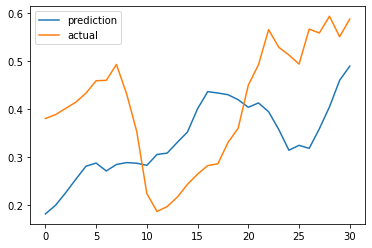

In [52]:
PV_SYSTEM_IDX = 8
ax = plt.axes()
ax.plot(model_output[EXAMPLE_IDX, :, PV_SYSTEM_IDX].detach(), label="prediction")
ax.plot(batch[BatchKey.pv][EXAMPLE_IDX, :, PV_SYSTEM_IDX], label="actual")
ax.legend();

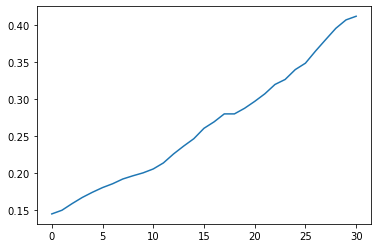

In [45]:
import numpy as np
plt.plot(np.nanmean(batch[BatchKey.pv][EXAMPLE_IDX, :, :], axis=1));

In [ ]:
model_output[EXAMPLE_IDX, :, PV_SYSTEM_IDX].squeeze().shape

torch.Size([31])

In [38]:
np.nanmean(batch[BatchKey.pv][EXAMPLE_IDX, :, :], axis=1)

array([0.26025552, 0.2826984 , 0.32713073, 0.34377894, 0.3367307 ,
       0.30448493, 0.28038296, 0.25917023, 0.23946783, 0.21943985,
       0.20914887, 0.21423626, 0.21939887, 0.22570351, 0.24262092,
       0.26491514, 0.28724864, 0.2948327 , 0.30184537, 0.30128288,
       0.28668693, 0.2657919 , 0.25260022, 0.2512227 , 0.2504408 ,
       0.25339133, 0.26884007, 0.2886405 , 0.3079026 , 0.32117432,
       0.3292083 ], dtype=float32)